In [24]:
import numpy as np
from scipy import stats
import pandas as pd
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.utils import resample
import statsmodels.stats.multitest as smt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [25]:
data = pd.read_excel('PD_data.xlsx')

In [26]:
data.shape

(195, 26)

In [27]:
data.isna().sum().sort_values(ascending=False)

name                0
S                   0
PPE                 0
D2                  0
spread2             0
spread1             0
DFA                 0
RPDE                0
HNR                 0
NHR                 0
Shimmer:DDA         0
MDVP:APQ            0
Shimmer:APQ5        0
Shimmer:APQ3        0
MDVP:Shimmer(dB)    0
MDVP:Shimmer        0
Jitter:DDP          0
MDVP:PPQ            0
MDVP:RAP            0
MDVP:Jitter(Abs)    0
MDVP:Jitter(%)      0
MDVP:Flo(Hz)        0
MDVP:Fhi(Hz)        0
MDVP:Fo(Hz)         0
Number              0
status              0
dtype: int64

In [28]:
data.dtypes

name                 object
S                    object
Number                int64
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
status                int64
dtype: object

In [29]:
data.columns

Index(['name', 'S', 'Number', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)',
       'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ',
       'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3',
       'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE', 'status'],
      dtype='object')

In [30]:
num_cols = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)','MDVP:Jitter(%)', 
            'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 
            'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 
            'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE','status']

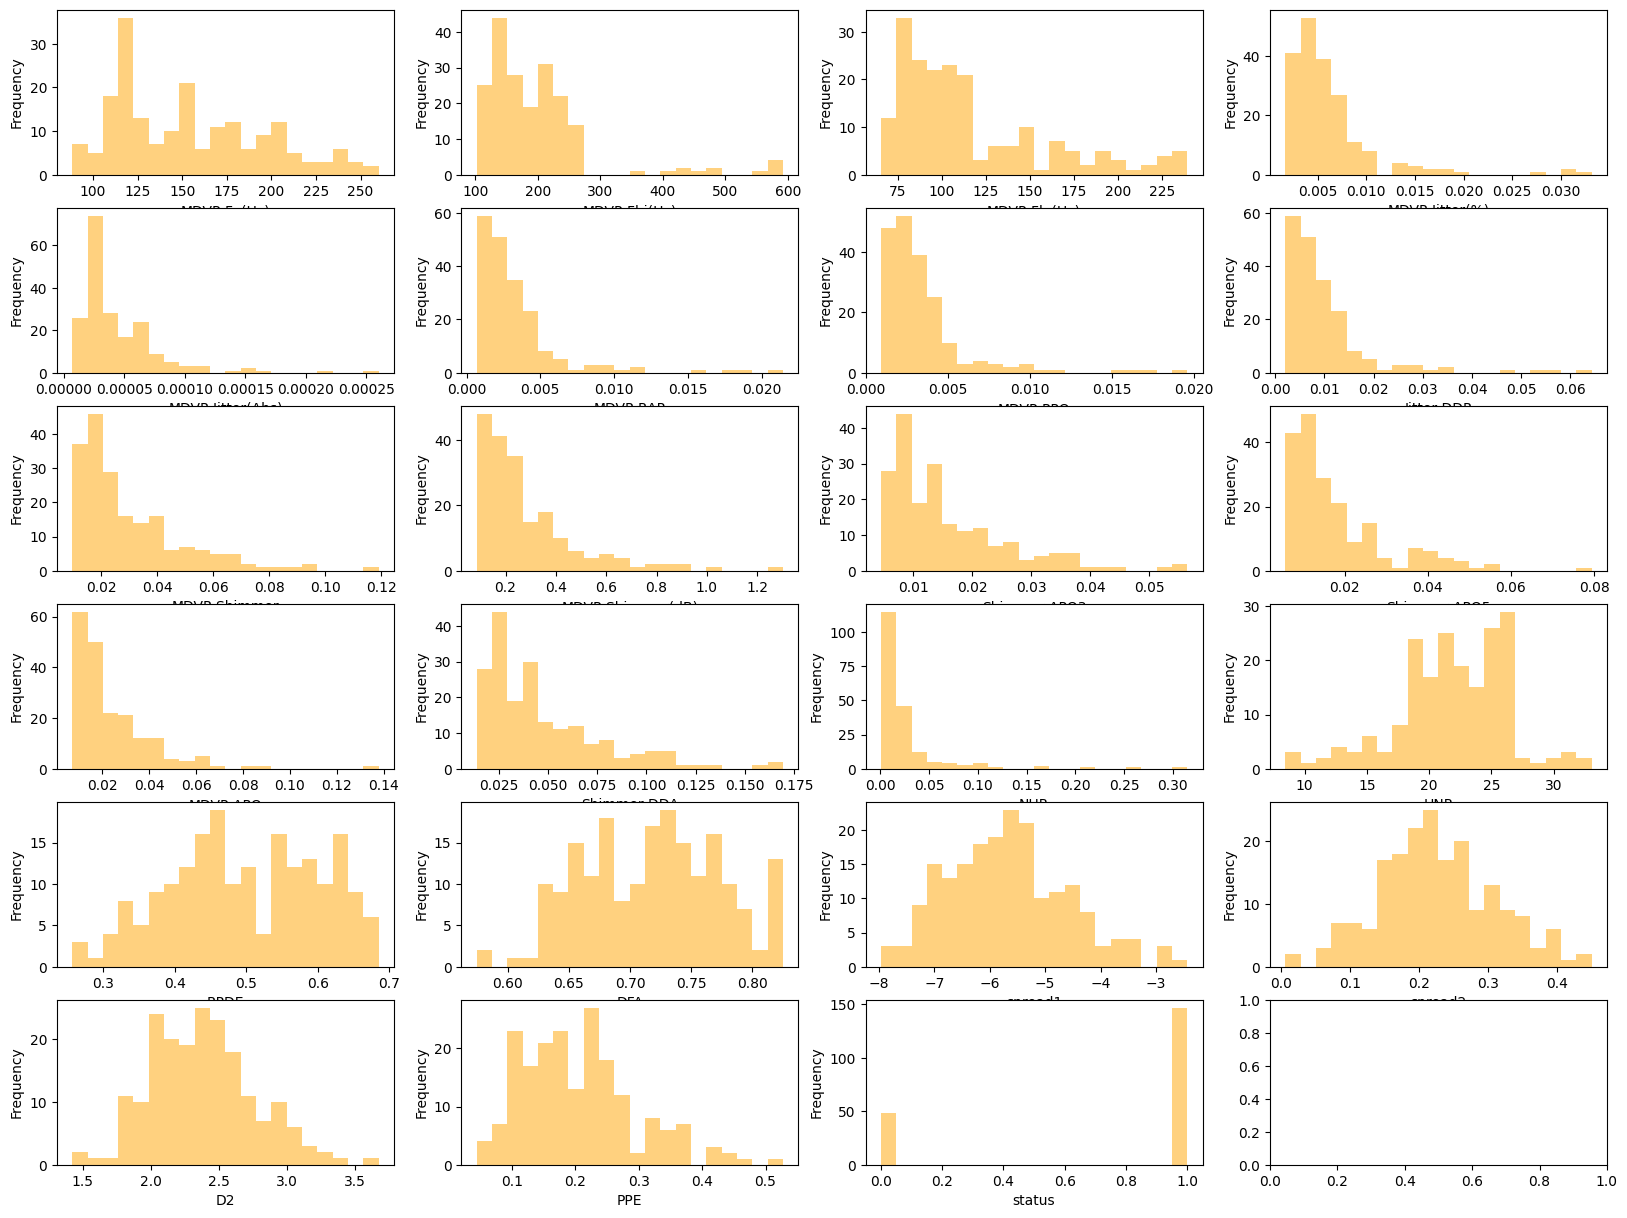

In [31]:
num_plots = len(num_cols)
num_rows = 6
no_cols = int(num_plots / num_rows) + (num_plots % num_rows > 0)
fig, axs = plt.subplots(nrows=num_rows, ncols=no_cols, figsize=(20, 15))

# iterate over the columns and plot a histogram for each numeric column
row = 0
col = 0
for column in num_cols:
    axs[row, col].hist(data[column], alpha=0.5, bins=20, color='orange')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Frequency')
    if col == (no_cols - 1):
        row += 1
        col = 0
    else:
        col += 1

# show the plot
plt.show()

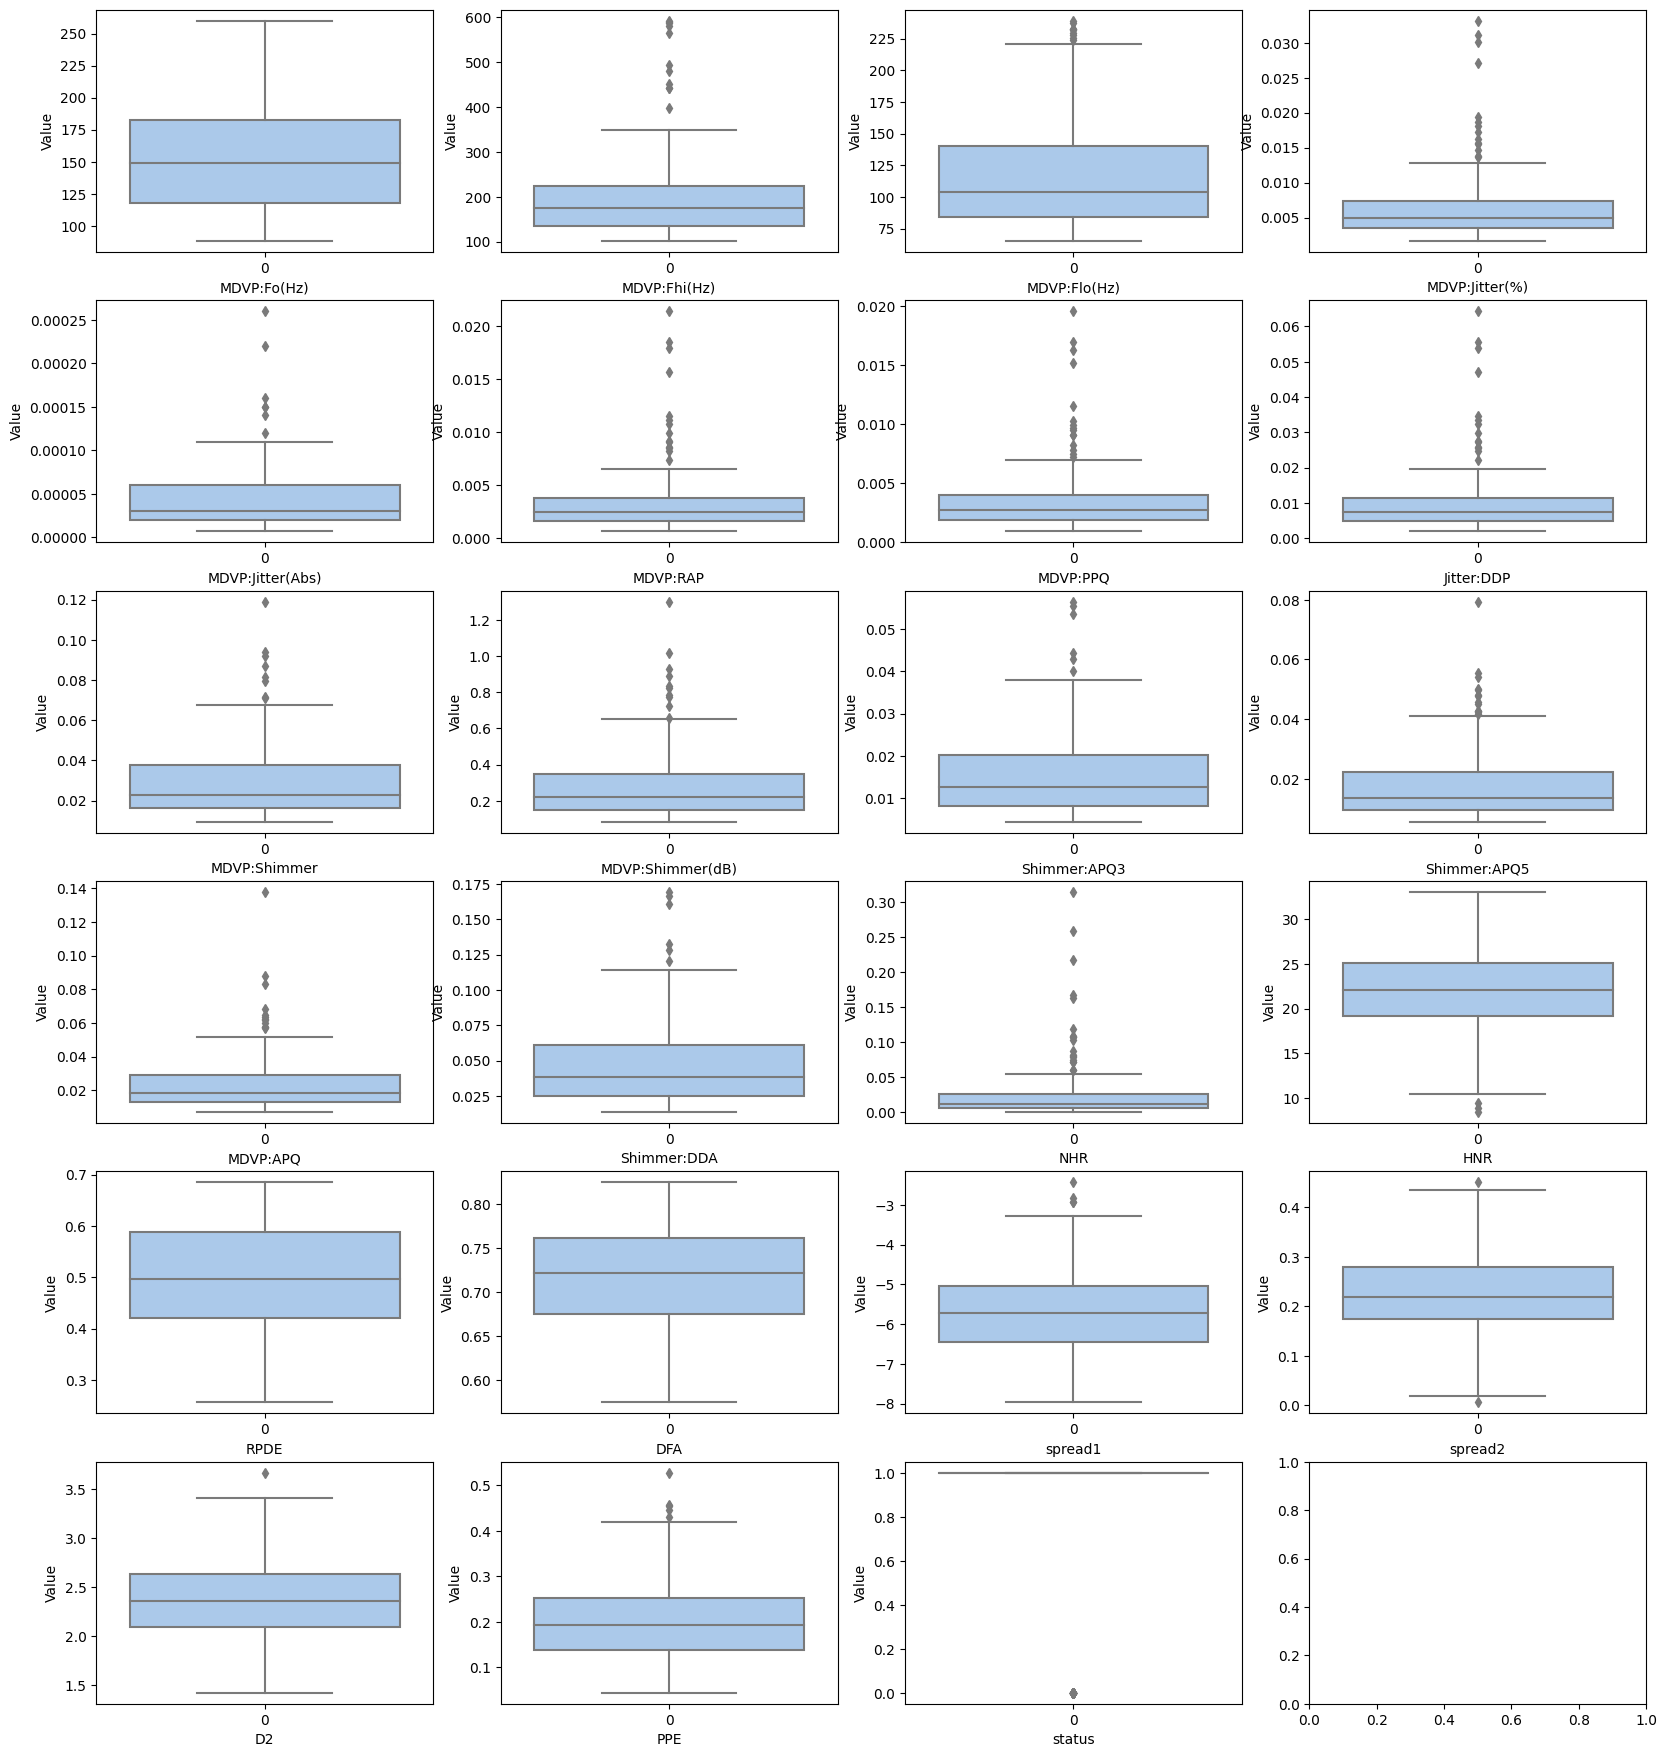

In [32]:
num_plots = len(num_cols)
num_rows = 6
n_cols = 4
fig, axs = plt.subplots(nrows=num_rows, ncols=n_cols, figsize=(20, 22))
# iterate over the columns and plot a box plot for each numeric column
row = 0
col = 0
for column in num_cols:
    sns.boxplot(data=data[column], ax=axs[row, col], palette="pastel")
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Value')
    if col == (n_cols - 1):
        row += 1
        col = 0
    else:
        col += 1

# show the plot
plt.show()

In [33]:
def f_test(df, independent_var, target_var):
    """
    Perform an F-test for equality of variances between two groups based on a binary target variable.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        independent_var (str): The name of the column containing the independent variable.
        target_var (str): The name of the column containing the binary target variable.

    Returns:
        A tuple containing the F-statistic and the p-value for the F-test.
    """
    # Split the data into two groups based on the binary target variable
    group1 = df.loc[df[target_var] == 0, independent_var]
    group2 = df.loc[df[target_var] == 1, independent_var]

    # Calculate the variances of the independent variable for each group
    var1 = group1.var(ddof=1)
    var2 = group2.var(ddof=1)

    # Calculate the F-statistic
    f_stat = var1 / var2

    # Calculate the degrees of freedom for the F-distribution
    df1 = len(group1) - 1
    df2 = len(group2) - 1

    # Calculate the p-value for the F-test
    p_value = f.sf(f_stat, df1, df2)

    # Return the F-statistic and the p-value
    return f_stat, p_value


ftest_results = pd.DataFrame(columns=['Independent Variable', 'F-Statistic', 'p-value'])

# Iterate over the columns in the DataFrame and apply the f_test function to each one
for col in num_cols:
    f_stat, p_value = f_test(data, col, 'status')
    ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)

# Print the results table
print(ftest_results)


   Independent Variable  F-Statistic       p-value
0           MDVP:Fo(Hz)     2.657278  4.433757e-06
1          MDVP:Fhi(Hz)     1.198918  2.075789e-01
2          MDVP:Flo(Hz)     3.314401  1.932652e-08
3        MDVP:Jitter(%)     0.153758  1.000000e+00
4      MDVP:Jitter(Abs)     0.165384  1.000000e+00
5              MDVP:RAP     0.108208  1.000000e+00
6              MDVP:PPQ     0.099025  1.000000e+00
7            Jitter:DDP     0.108263  1.000000e+00
8          MDVP:Shimmer     0.077082  1.000000e+00
9      MDVP:Shimmer(dB)     0.077429  1.000000e+00
10         Shimmer:APQ3     0.102454  1.000000e+00
11         Shimmer:APQ5     0.063252  1.000000e+00
12             MDVP:APQ     0.044848  1.000000e+00
13          Shimmer:DDA     0.102463  1.000000e+00
14                  NHR     0.184438  1.000000e+00
15                  HNR     0.626512  9.674013e-01
16                 RPDE     0.829134  7.685942e-01
17                  DFA     0.878352  6.909394e-01
18              spread1     0.4

/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/1483611799.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)
/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/1483611799.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)
/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/1483611799.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_st

In [34]:
corr_matrix = data[num_cols].corr()

# compute the p-values for the correlation coefficients
p_values = data[num_cols].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(num_cols))

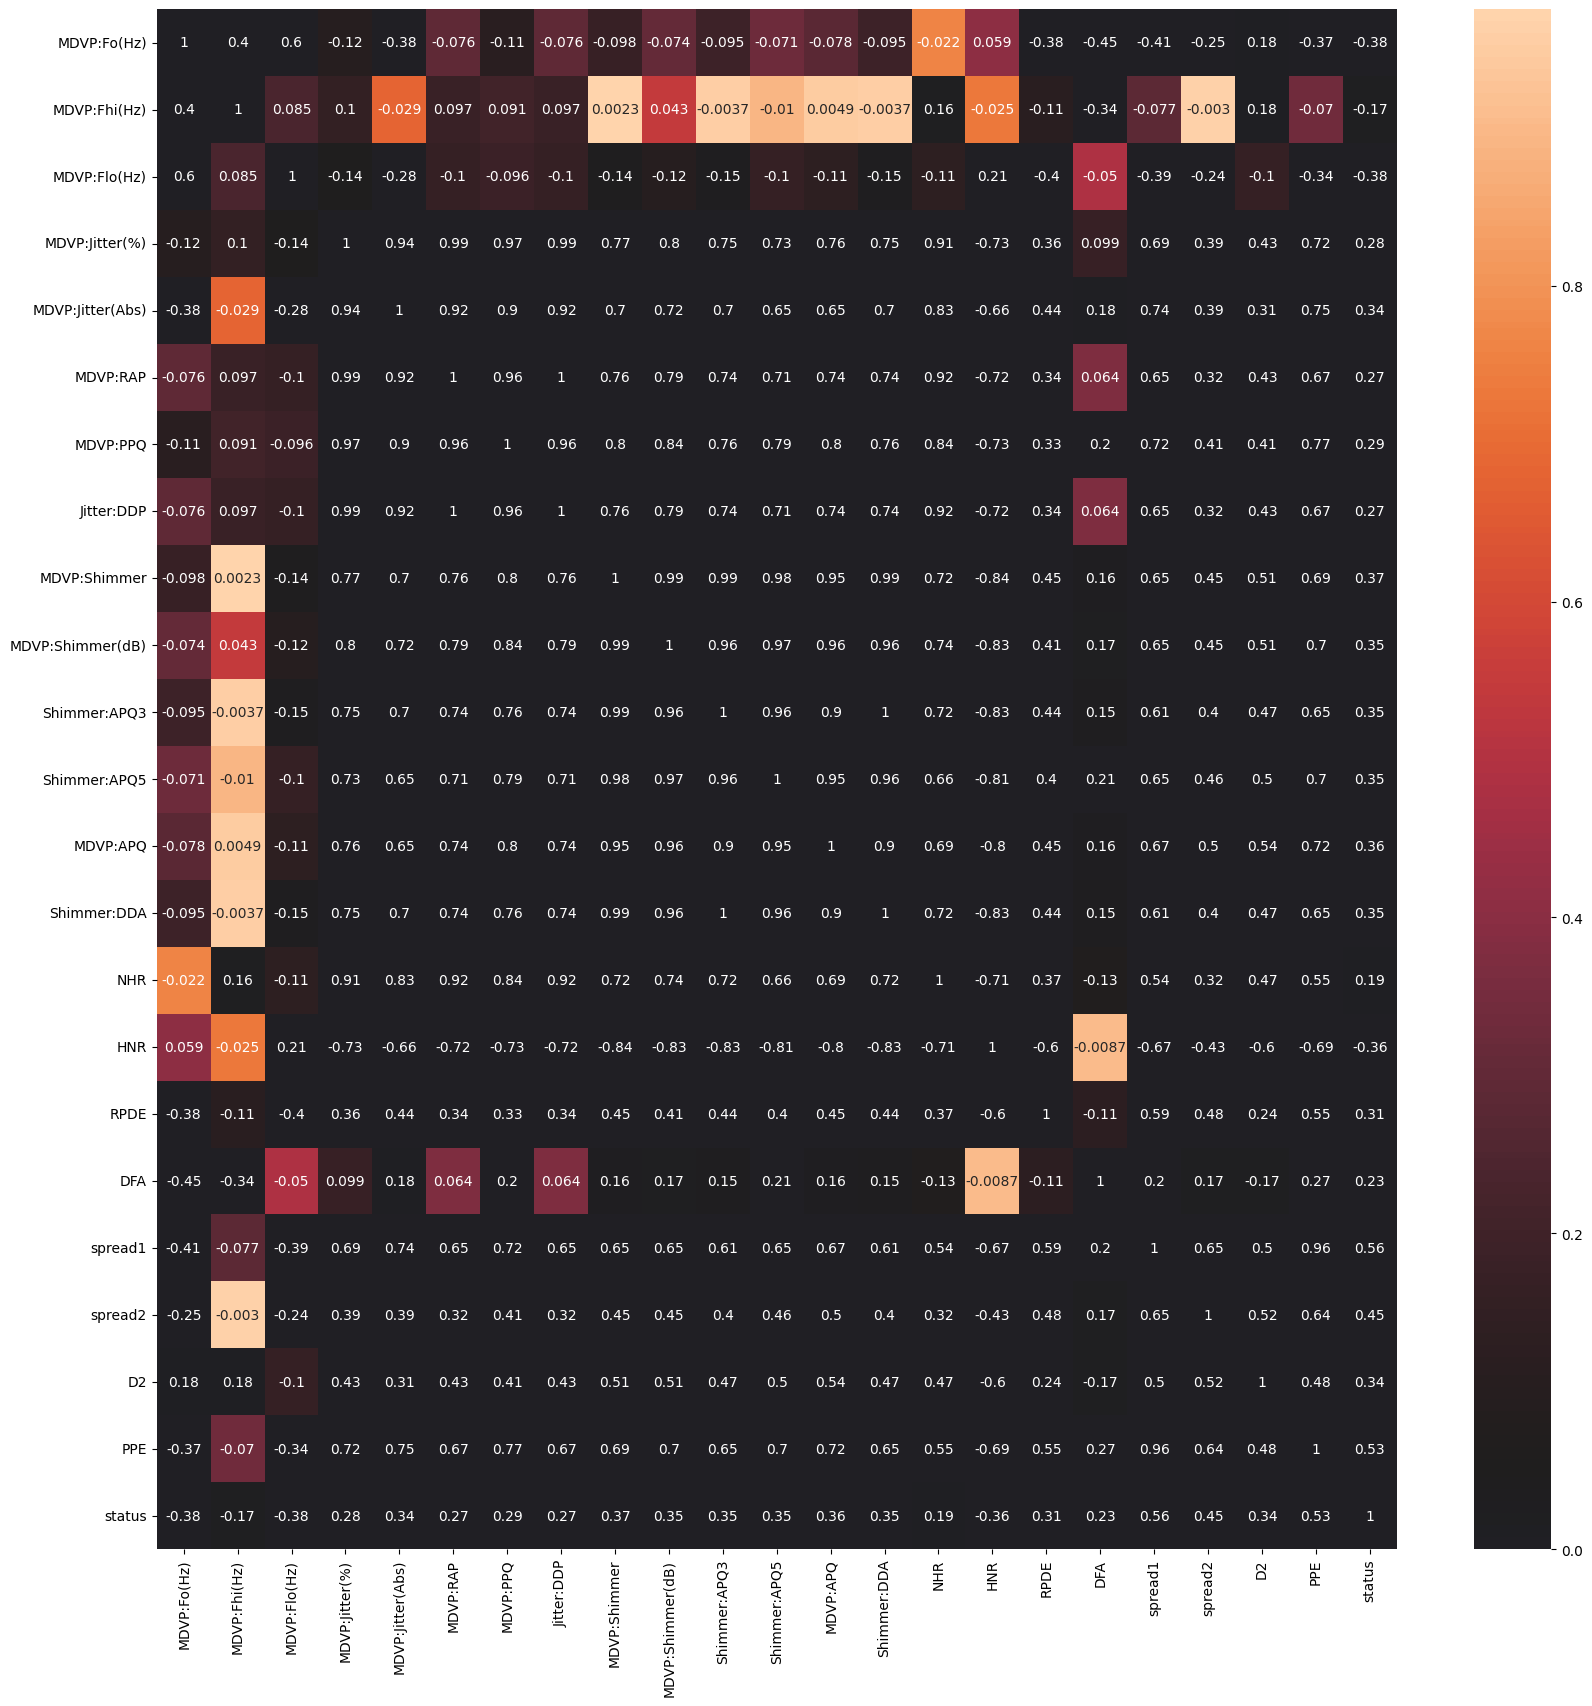

In [38]:
plt.figure(figsize=(20,20))
plot = sns.heatmap(p_values, annot = corr_matrix, center = 0.05)

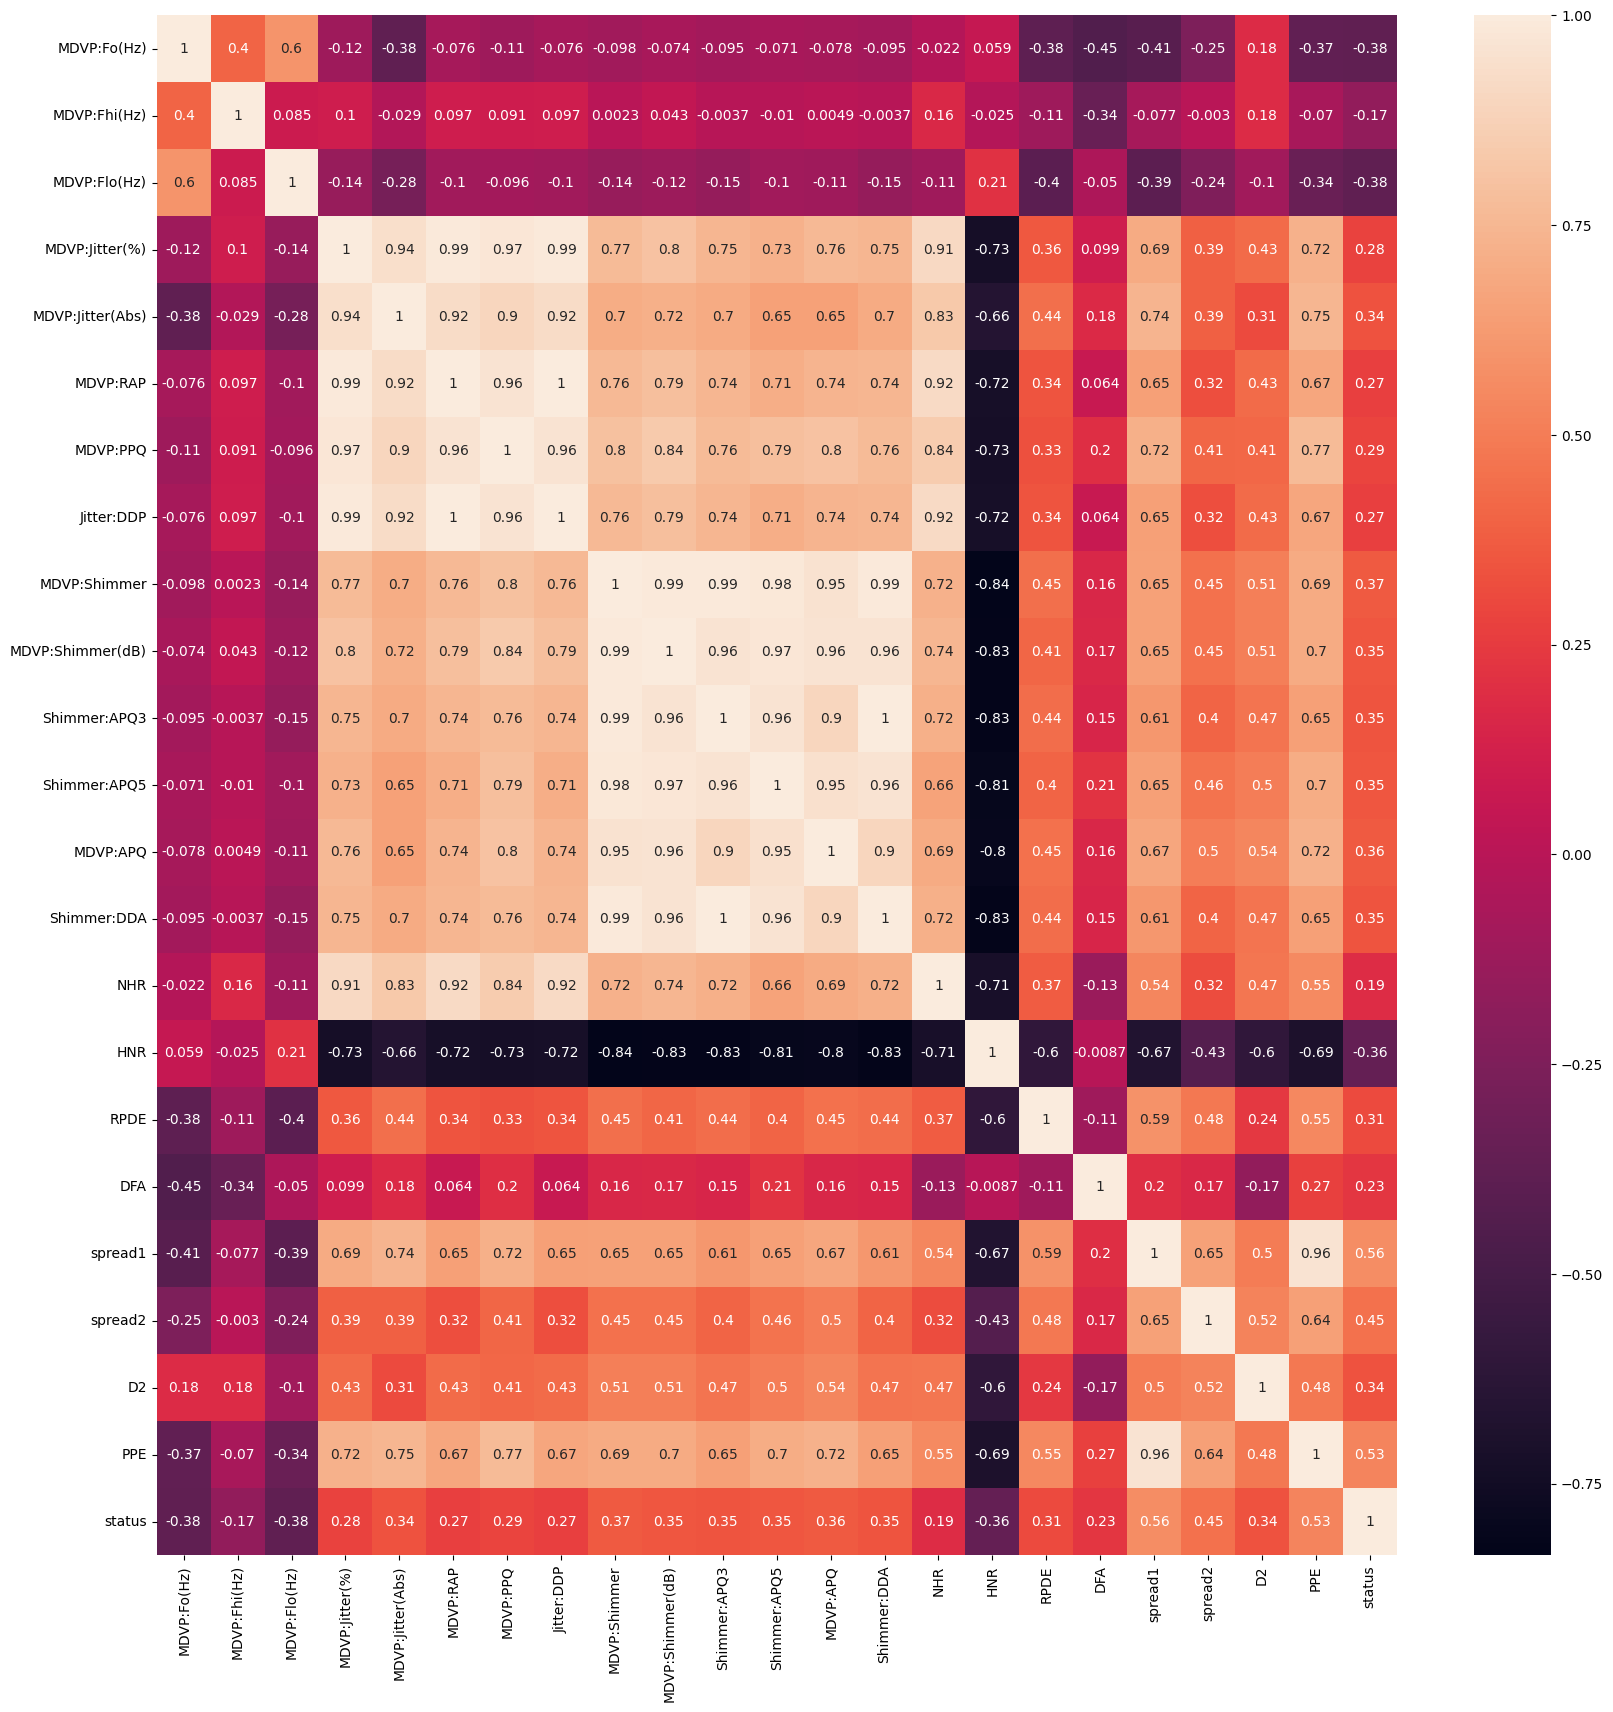

In [40]:
plt.figure(figsize=(20,20))
plot = sns.heatmap(corr_matrix, annot = corr_matrix)

In [48]:
variation_freq = ['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP']
variation_amp = ['MDVP:Shimmer', 'MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA']
fund_freq_vars = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)']

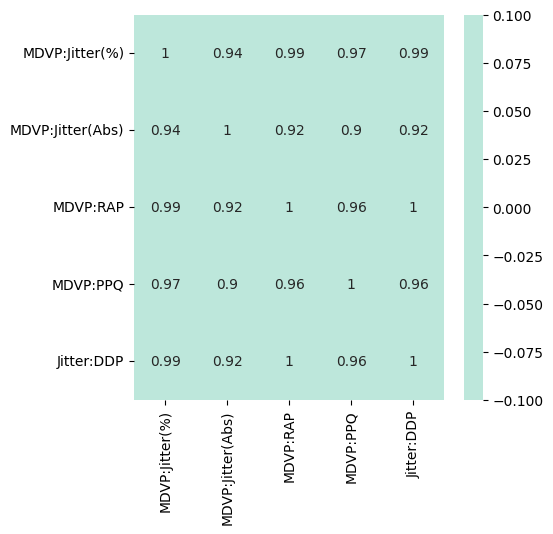

In [56]:
frequency_corr_matrix = data[variation_freq].corr()

# compute the p-values for the correlation coefficients
frequency_p_values = data[variation_freq].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(variation_freq))

plt.figure(figsize=(5,5))
plot = sns.heatmap(frequency_p_values, annot = frequency_corr_matrix, center = 0.05)

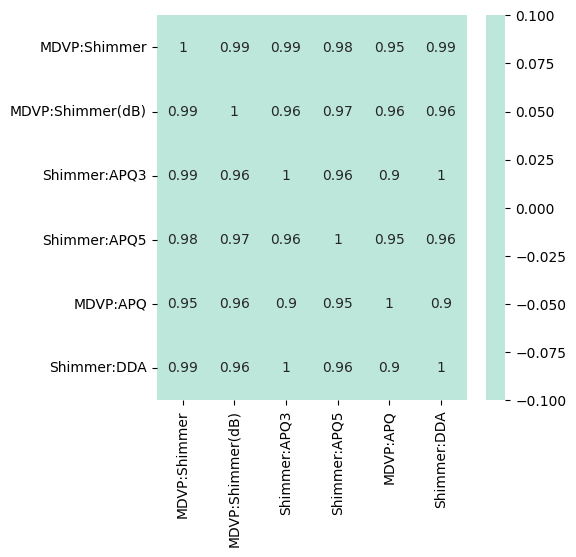

In [57]:
amplitude_corr_matrix = data[variation_amp].corr()

# compute the p-values for the correlation coefficients
amplitude_p_values = data[variation_amp].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(variation_amp))

plt.figure(figsize=(5,5))
plot = sns.heatmap(amplitude_p_values, annot = amplitude_corr_matrix, center = 0.05)

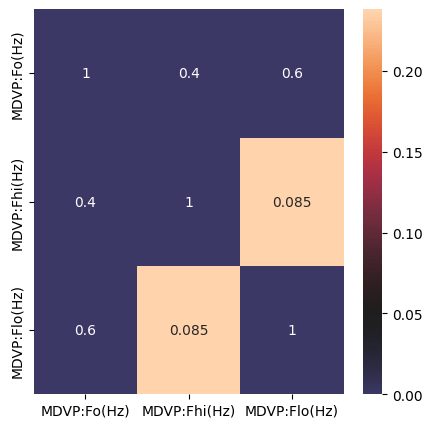

In [61]:
fundfreq_corr_matrix = data[fund_freq_vars].corr()

# compute the p-values for the correlation coefficients
fundfreq_p_values = data[fund_freq_vars].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(fund_freq_vars))

plt.figure(figsize=(5,5))
plot = sns.heatmap(fundfreq_p_values, annot = fundfreq_corr_matrix, center = 0.05)